In [1]:
import h5py
import numpy as np
import torch
import logging
import time
import matplotlib.pyplot as plt

ftype = torch.float32
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
s_box = [
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
]
s_box_tensor = torch.tensor(s_box, dtype=torch.int32)
hamming_weight = torch.tensor([np.bitwise_count(i) for i in range(256)], dtype=ftype)

Dataset from:
https://github.com/ANSSI-FR/ASCAD/tree/master/STM32_AES_v2

Contains traces of AES encryptions protected with shuffling and boolean masking. The order within operations SubBytes, ShiftRows and MixColumns is shuffled

In [3]:
file_path = "ASCAD_databases/ATMega8515_raw_traces.h5"
f = h5py.File(file_path)
f.keys()

<KeysViewHDF5 ['metadata', 'traces']>

In [4]:
f["metadata"].dtype, f["traces"].shape

(dtype([('plaintext', 'u1', (16,)), ('ciphertext', 'u1', (16,)), ('key', 'u1', (16,)), ('masks', 'u1', (16,))]),
 (60000, 100000))

From metadata we'll use plaintext for CPA, and key to verify our results. We won't be using the masks, that are used to obfuscate sbox output.

In [5]:
key = f["metadata"]["key"]
np.all(key[0] == key)

np.True_

Since all traces used the same key, and we have both plaintext and traces we can perform an SCA attack.

In [6]:
def correlate_traces(plaintext: torch.tensor,
                     traces_centered: torch.tensor,
                     traces_centered_squared_sum: torch.tensor):
    """
    Computes Pearson's R correlation between hamming weights of sbox output for
    each key hypothesis, and traces for each of 256 key hypotheses.

    Correlation is computed as Pearson's r, based on formula:
    correlation = Cov(iv, trace)
                  / ( std(iv) * std(trace))

    Using vectorized computation, this is performed as
    correlation = dot_product((iv - mean(iv), (trace - mean(trace))
                  / sqrt( (iv - mean(iv))^2 * (trace - mean(trace)^2)

    Performance increase is gained by using precomputed traces_centered as well
    as traces_std. 

    Assumes
    - i = amount of traces
    - j = amount of samples per trace
    :plaintexts: tensor of the specific byte of plaintext, shaped (i, 1)
    :traces_centered: precomputed traces - traces.mean(axis=0), shaped (i, j)
    :traces_std: precomputed traces.std(axis=0) shaped (j,)

    :returns: array of correlations shaped (256, j)
    """
    I = plaintext.shape[0]
    iv = torch.zeros((256, I), dtype=ftype)
    for key_hypothesis in range(256):
        # Sbox(key_hypothesis ^ plaintext)
        xor = key_hypothesis ^ plaintext
        switch = s_box_tensor[xor]
        
        # hamming weight of sbox output
        weights = hamming_weight[switch]
        iv[key_hypothesis] = weights
    iv_centered = iv - iv.mean(dim=1, keepdim=True)
    iv_centered_squared_sum = torch.sum(iv_centered**2, dim=1, keepdim=True)

    # (iv - iv.mean()) * (traces - traces.mean(dim=0))
    # matrix multiplication between iv_{256, I} and traces_{I, J}
    nom = torch.matmul(iv_centered, traces_centered) 
    # sqrt(sum(iv - iv.mean())**2 * sum(traces - traces.mean(dim=0))**2)
    # inner multiplication is between iv_{256, 1} and traces_{1, J}
    denom = torch.sqrt(iv_centered_squared_sum * traces_centered_squared_sum)
    return nom / denom


The size of traces is quite large at 5.59GB. This will increase four-fold after computing trace.mean() due to conversion to float32. As such correlations will be computed over trace slices during multiple epochs

In [7]:
epochs = 8
with h5py.File(file_path) as f:
    plaintext = f["metadata"]["plaintext"]
    
    plaintext = torch.tensor(plaintext, dtype=torch.int32)

    traces_shape = f["traces"].shape
    step = traces_shape[1] // epochs

In [8]:
corrs = torch.zeros((16, 256, traces_shape[1]), dtype=ftype)
# perform CPA for each key byte over trace splices 

with h5py.File(file_path) as f:
    for i in range(epochs):
        start_time = time.time()
        # prepare another batch of traces
        traces = f["traces"][:, step * i: step * (i + 1)]
        traces = torch.tensor(traces, dtype=ftype)
        traces_centered = traces - traces.mean(dim=0)
        traces_squared_diff_sum = torch.sum(traces_centered**2, dim=0, keepdim=True)
        del traces
        logger.info(f"epoch {i} loaded in {time.time() - start_time:.2f}")

        start_time = time.time()
        # compute correlations
        for key_byte in range(16):
            epoch_correlations = correlate_traces(plaintext[:, key_byte],
                                                  traces_centered,
                                                  traces_squared_diff_sum)
            corrs[key_byte, :, step*i: step*(i+1)] = epoch_correlations
        logger.info(f"epoch {i} computed in {time.time() - start_time:.2f}")

del traces_centered

INFO:__main__:epoch 0 loaded in 11.46
INFO:__main__:epoch 0 computed in 5.56
INFO:__main__:epoch 1 loaded in 9.70
INFO:__main__:epoch 1 computed in 5.11
INFO:__main__:epoch 2 loaded in 9.88
INFO:__main__:epoch 2 computed in 5.09
INFO:__main__:epoch 3 loaded in 9.52
INFO:__main__:epoch 3 computed in 5.11
INFO:__main__:epoch 4 loaded in 9.40
INFO:__main__:epoch 4 computed in 5.26
INFO:__main__:epoch 5 loaded in 10.65
INFO:__main__:epoch 5 computed in 5.16
INFO:__main__:epoch 6 loaded in 9.17
INFO:__main__:epoch 6 computed in 5.09
INFO:__main__:epoch 7 loaded in 10.90
INFO:__main__:epoch 7 computed in 5.31


We work with absolute values, as the direction of correlation does not matter

In [9]:
abscorr = corrs.abs()
# maximum correlation of each key hypotesis, with sample index
hypo_max_correlation, hypo_sample_index = abscorr.max(dim=2)
# maximum correlation of byte, along corresponding key hypothesis
byte_max_correlation, byte_guess = hypo_max_correlation.max(dim=1)

In [33]:
def check_byte(byte_index, key):
    order = (-hypo_max_correlation[byte_index]).argsort()
    rank = order.argsort() + 1

    print(f"{byte_index:2}-th byte was is ranked {rank[key]:3} at sample {hypo_sample_index[byte_index, key]}")
    print(f"      reached maximum correlation {byte_max_correlation[byte_index]:.3f}")
            

In [34]:
for byte in range(16):
    check_byte(byte, key[0, byte])

 0-th byte was is ranked   1 at sample 32691
      reached maximum correlation 0.916
 1-th byte was is ranked   1 at sample 26448
      reached maximum correlation 0.911
 2-th byte was is ranked   1 at sample 92173
      reached maximum correlation 0.037
 3-th byte was is ranked   1 at sample 98106
      reached maximum correlation 0.044
 4-th byte was is ranked   1 at sample 91183
      reached maximum correlation 0.038
 5-th byte was is ranked   1 at sample 41860
      reached maximum correlation 0.108
 6-th byte was is ranked   1 at sample 96128
      reached maximum correlation 0.036
 7-th byte was is ranked   1 at sample 97118
      reached maximum correlation 0.033
 8-th byte was is ranked  96 at sample 18876
      reached maximum correlation 0.021
 9-th byte was is ranked   1 at sample 95140
      reached maximum correlation 0.039
10-th byte was is ranked  78 at sample 74214
      reached maximum correlation 0.021
11-th byte was is ranked   1 at sample 93162
      reached maximu

Our attack succesfully recovered 11 out of 16 key bytes with high correlations on many gueses.

In [12]:
def graph_correlation(byte_index):
    correct_key_byte = key[0, byte_index]
    array = corrs[byte_index]
    for i in range(256):
        if i == correct_key_byte:
            color = "green"
        else:
            color = "gray"
        plt.plot(array[i], color=color)
    plt.title(f"{byte_index}-th key byte")
    plt.show()

why did we recover bytes 0 and 1 so well, are they not protected?
there's boolean masking, is it applied to these bytes as well?

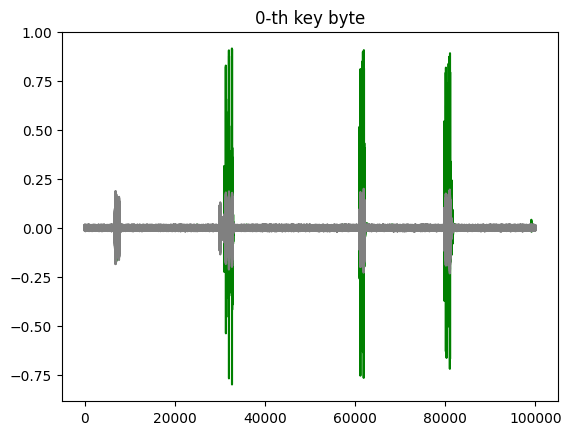

 0-th byte hypothesis  77 is the correct byte
      reached at sample 32691 has correlation 0.916


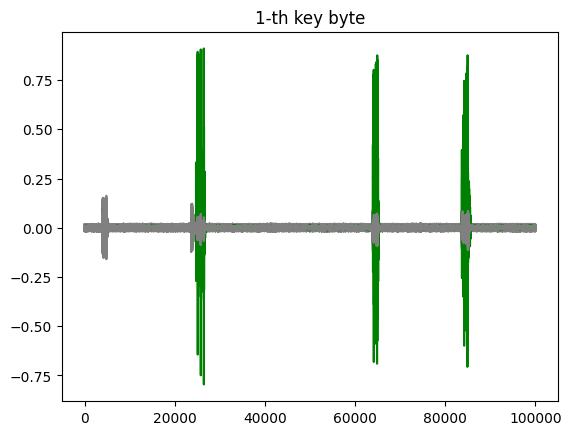

 1-th byte hypothesis 251 is the correct byte
      reached at sample 26448 has correlation 0.911


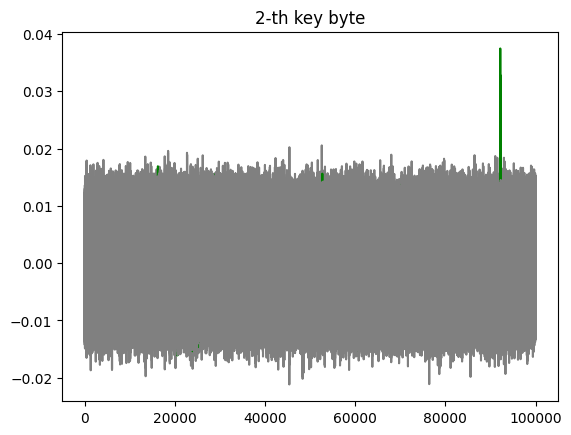

 2-th byte hypothesis 224 is the correct byte
      reached at sample 92173 has correlation 0.037


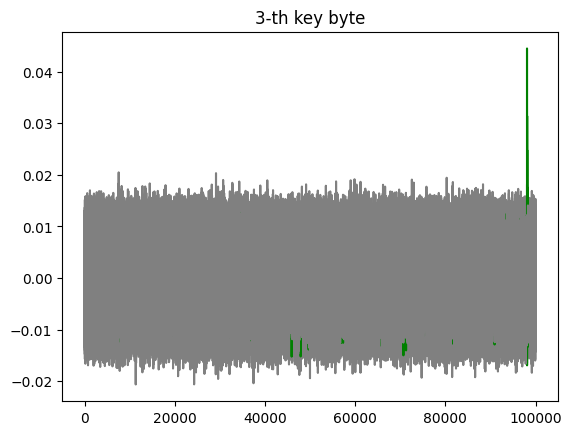

 3-th byte hypothesis 242 is the correct byte
      reached at sample 98106 has correlation 0.044


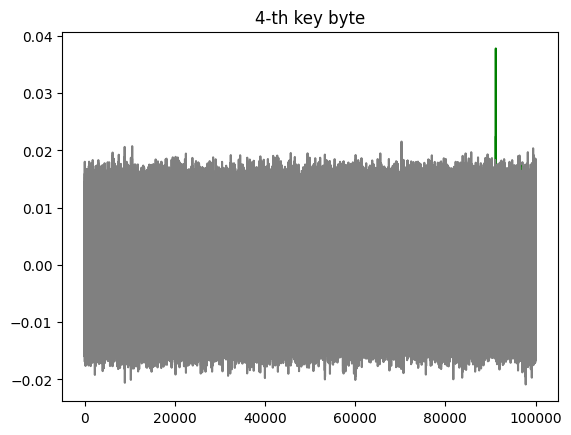

 4-th byte hypothesis 114 is the correct byte
      reached at sample 91183 has correlation 0.038


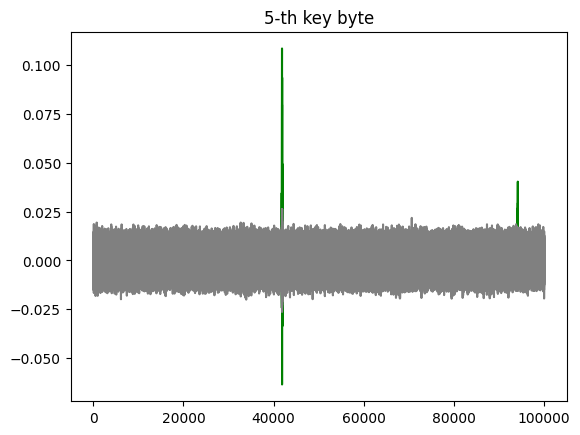

 5-th byte hypothesis  33 is the correct byte
      reached at sample 41860 has correlation 0.108


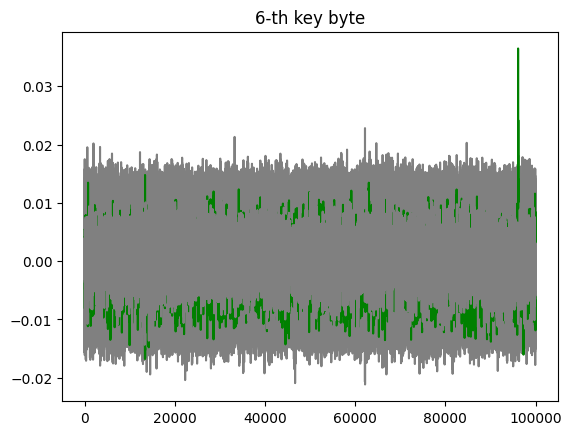

 6-th byte hypothesis 254 is the correct byte
      reached at sample 96128 has correlation 0.036


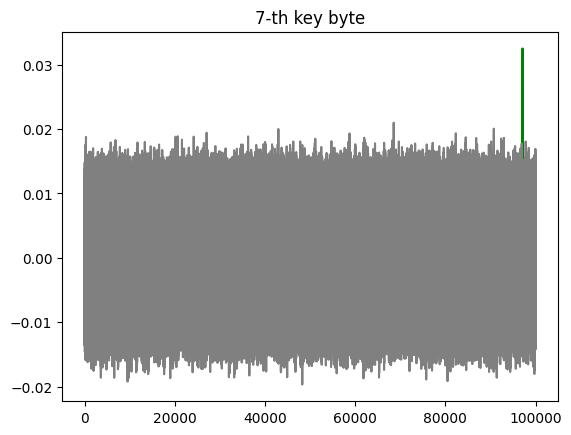

 7-th byte hypothesis  16 is the correct byte
      reached at sample 97118 has correlation 0.033


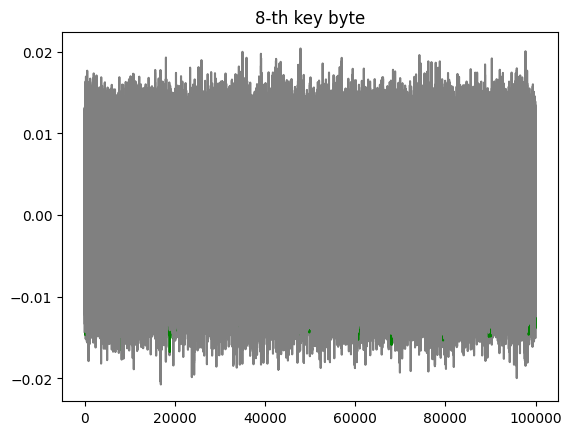

 8-th byte hypothesis   4
      reached at sample 16898 has correlation 0.021
      key is 167, rank  96 with 0.017


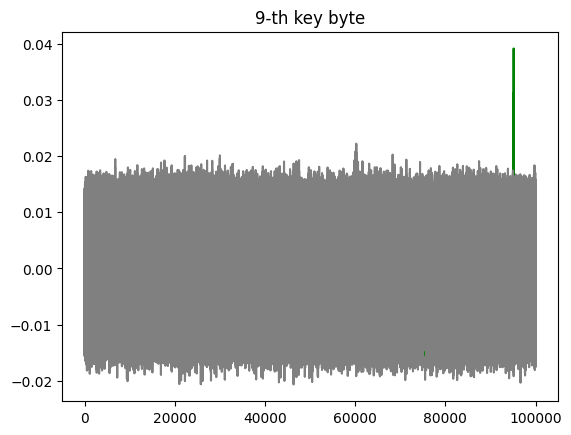

 9-th byte hypothesis 141 is the correct byte
      reached at sample 95140 has correlation 0.039


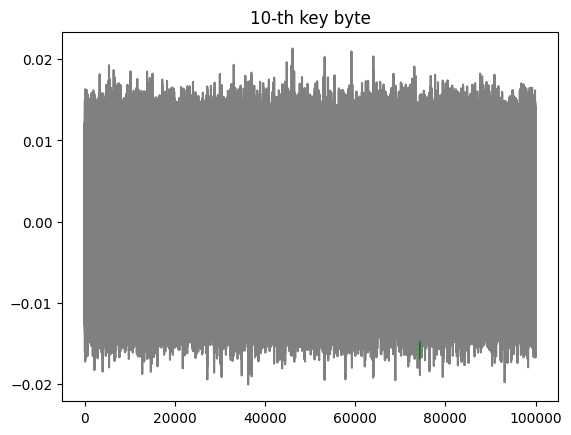

10-th byte hypothesis 240
      reached at sample 46104 has correlation 0.021
      key is  74, rank  78 with 0.017


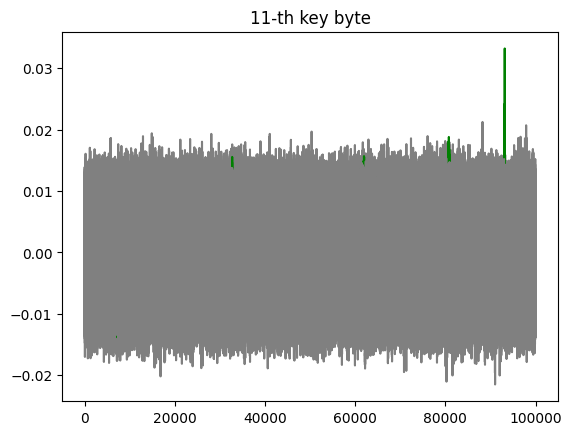

11-th byte hypothesis 220 is the correct byte
      reached at sample 93162 has correlation 0.033


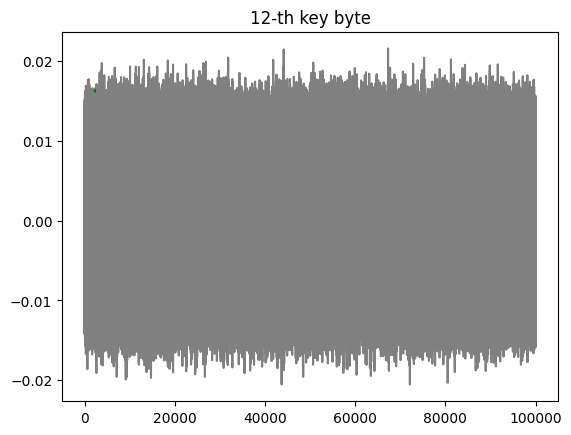

12-th byte hypothesis 225
      reached at sample 67291 has correlation 0.022
      key is 142, rank 131 with 0.016


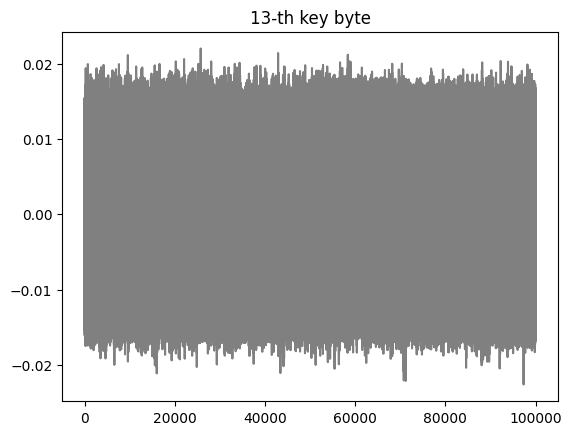

13-th byte hypothesis  57
      reached at sample 97347 has correlation 0.023
      key is  73, rank 253 with 0.014


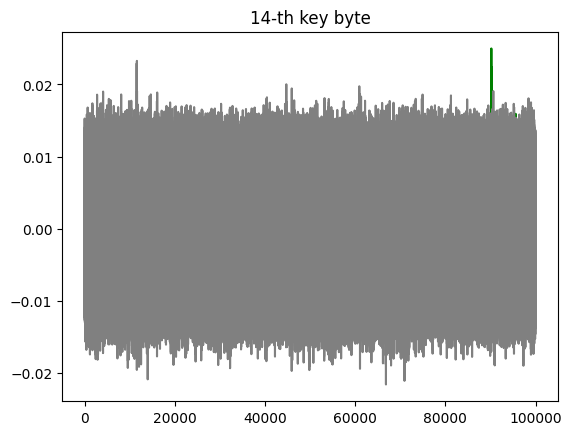

14-th byte hypothesis   4 is the correct byte
      reached at sample 90194 has correlation 0.025


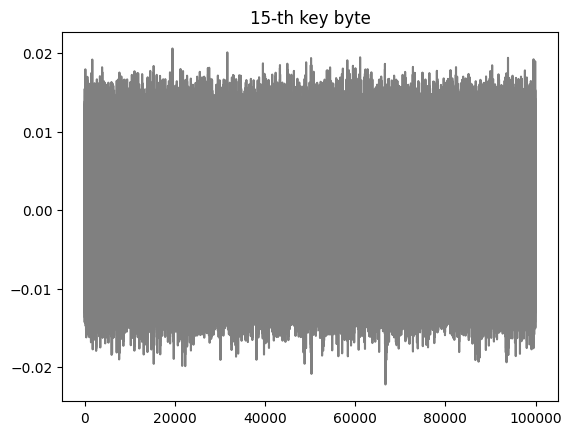

15-th byte hypothesis 255
      reached at sample 66717 has correlation 0.022
      key is 105, rank 216 with 0.015


In [13]:
for byte in range(16):
    graph_correlation(byte)
    check_byte(byte, key[0, byte])

Correlation for correct key bytes 0 and 1 hypothesis spiked 3 times. This is expected, as the same intermediate value, obtained as a result of SubBytes is then manipulated in ShiftRows and MixColumns.

Most of the other key bytes had relatively low correlation, with only notable peaks reaching 0.04, slightly above the baseline noise of around 0.02. Furthermore, this increase was not reached during the SubBytes operation, appearing near the end of the round.

Hypothesis for key byte 5 achieved a spike in correlation during the SubBytes operation, reaching 0.1.

we can also compare correlations of all hypotheses on sample with highest correlation

In [ ]:
def show_best_sample(byte_index):
    best_hypo = byte_guess[byte_index]
    print(hypo_sample_index.shape)
    sample = hypo_sample_index[byte_index, best_hypo]
    plt.plot(corrs[byte_index, :, sample])
    plt.title(f"{byte_index}-th byte - sample {hypo_sample_index[byte, byte_guess[byte]]}")

torch.Size([16, 256])


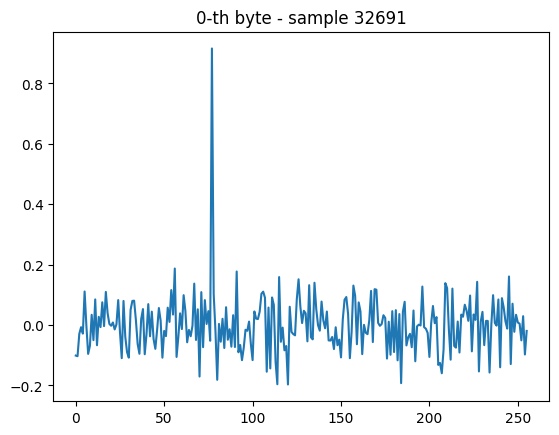

torch.Size([16, 256])


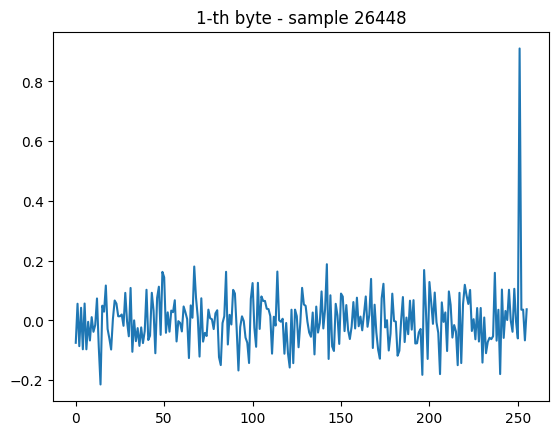

torch.Size([16, 256])


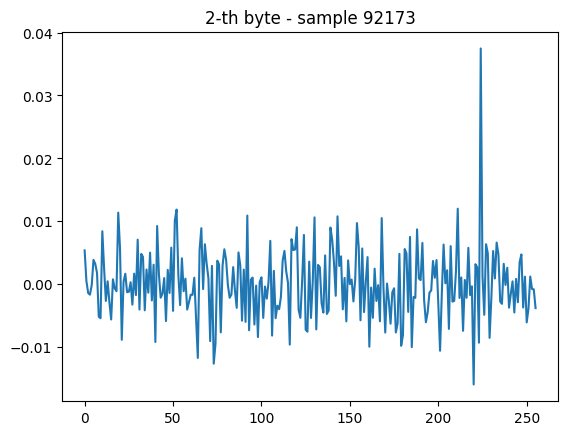

torch.Size([16, 256])


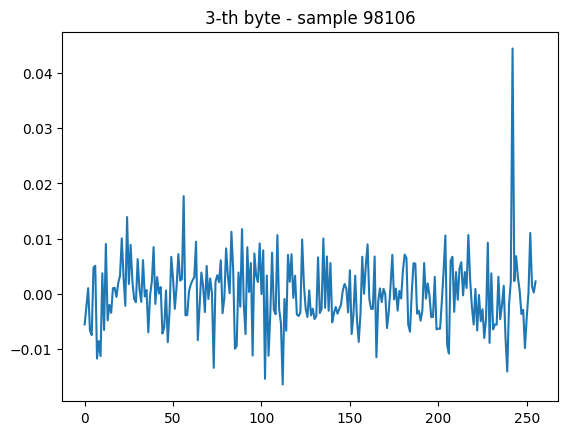

torch.Size([16, 256])


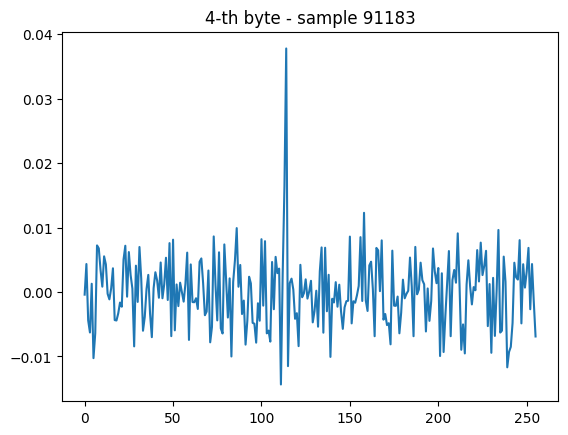

torch.Size([16, 256])


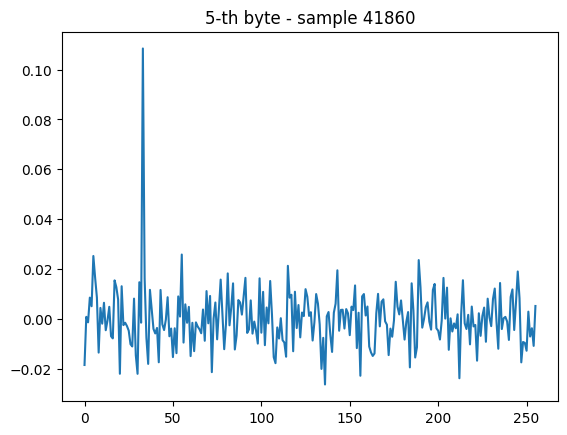

torch.Size([16, 256])


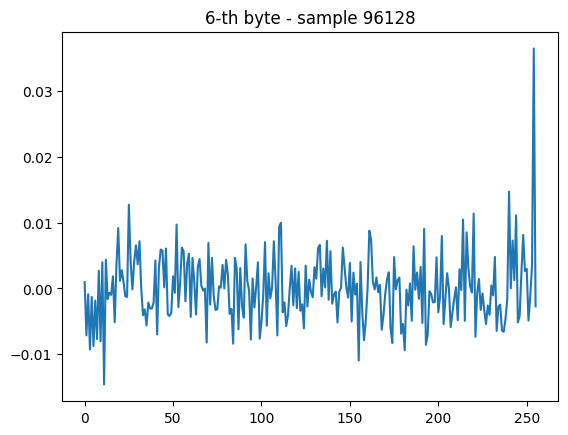

torch.Size([16, 256])


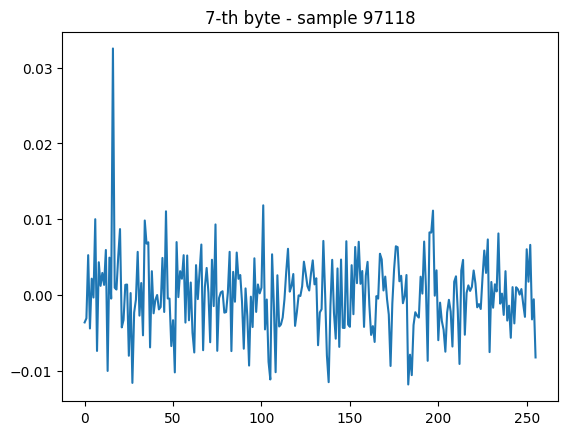

torch.Size([16, 256])


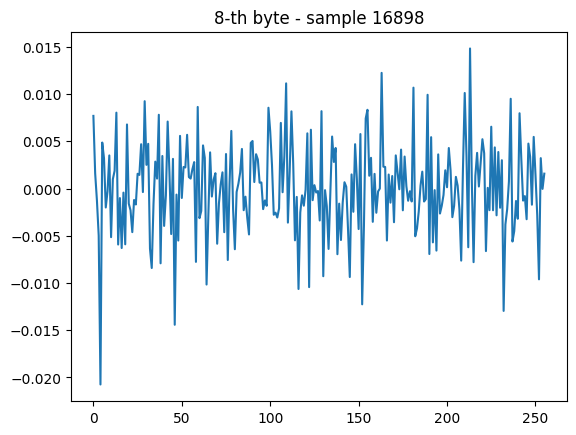

torch.Size([16, 256])


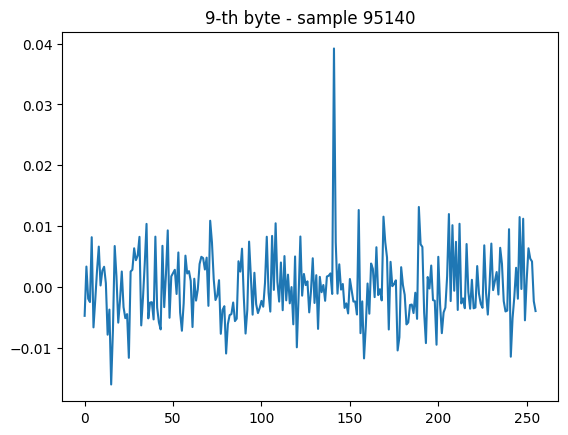

torch.Size([16, 256])


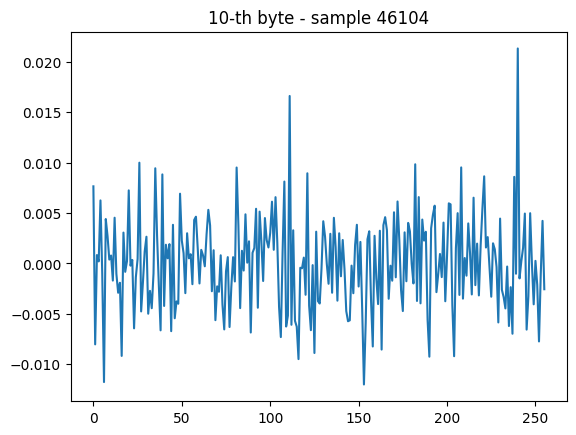

torch.Size([16, 256])


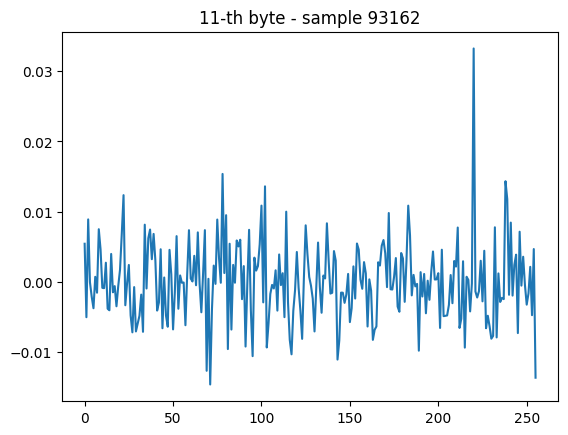

torch.Size([16, 256])


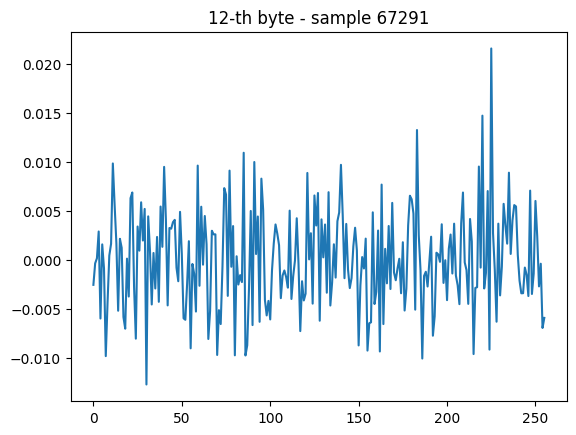

torch.Size([16, 256])


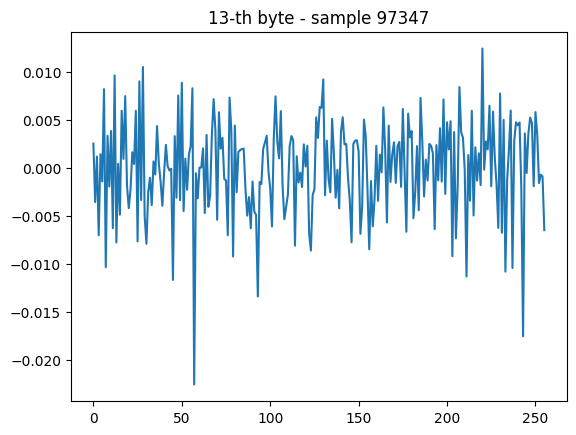

torch.Size([16, 256])


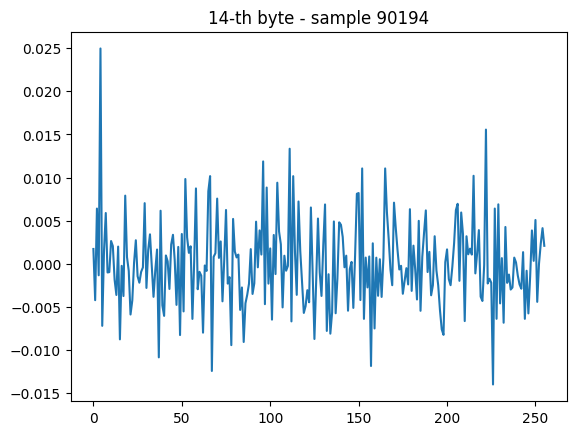

torch.Size([16, 256])


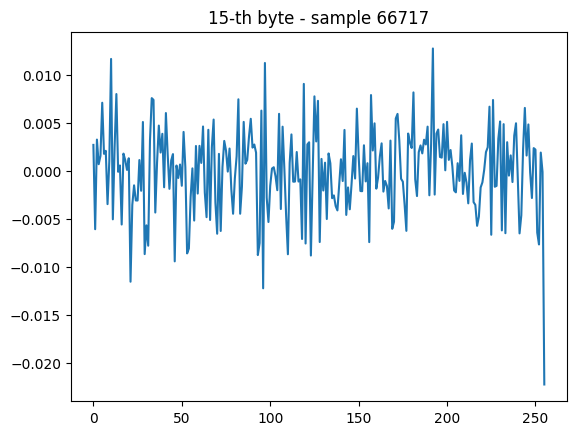

In [15]:
for byte in range(16):
    show_best_sample(byte)
    plt.show()

Lastly, we may calculate signal-to-noise ratio based on mask_out, in order to help diagnose the spike in 5-th byte.

In [16]:
def compute_snr(traces, values, num_classes):
    """
    traces: (N, T)
    values: (N,) — leakage model values (e.g., r_out)
    num_classes: number of possible values (e.g., 256)

    :returns: snr (T,) — signal-to-noise ratio per sample
    """
    S = traces.shape[1]
    snr = torch.zeros(S, dtype=traces.dtype, device=traces.device)

    for c in range(num_classes):
        mask = (values == c)
        if mask.sum() == 0:
            continue

        class_traces = traces[mask]  # shape: (Nc, S)
        mean_c = class_traces.mean(dim=0)             # (S,)
        var_c = class_traces.var(dim=0, unbiased=False)  # (S,)

        if c == 0:
            mean_all = mean_c.unsqueeze(0)
            var_all = var_c.unsqueeze(0)
            class_counts = torch.tensor([mask.sum()], device=traces.device)
        else:
            mean_all = torch.cat((mean_all, mean_c.unsqueeze(0)), dim=0)
            var_all = torch.cat((var_all, var_c.unsqueeze(0)), dim=0)
            class_counts = torch.cat((class_counts, mask.sum().unsqueeze(0)))

    # Normalize weights
    weights = class_counts.float() / class_counts.sum()
    # Compute SNR per sample
    mean_signal = (weights.unsqueeze(1) * mean_all).sum(dim=0)  # (T,)
    signal_var = ((weights.unsqueeze(1) * (mean_all - mean_signal.unsqueeze(0))**2).sum(dim=0))
    noise_var = (weights.unsqueeze(1) * var_all).sum(dim=0)

    snr = signal_var / (noise_var + 1e-12)  # prevent div by 0
    return snr

In [17]:
with h5py.File("ASCAD_databases/ATMega8515_raw_traces.h5") as f:
    rout = torch.tensor(f["metadata"]["masks"][:, 15], dtype=torch.int32)
    rout = torch.index_select(hamming_weight, 0, rout)
    traces_shape = f["traces"].shape
    step = 10000
    snr = None
    for i in range(0, traces_shape[1], step):
        traces = torch.tensor(f["traces"][:, i: i + step], dtype=torch.float32)
        mid = compute_snr(traces, rout, num_classes=9)
        del traces
        if snr is None:
            snr = mid
        else:
            snr = torch.cat((snr, mid), dim=0)

del mid
x = torch.arange(0, snr.shape[0])

Text(0.5, 1.0, 'SNR based on mask_out')

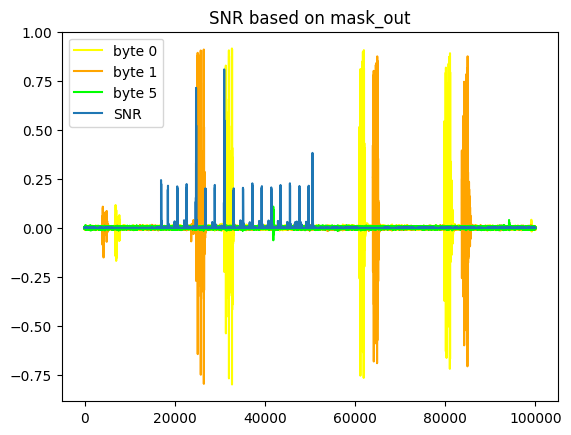

In [18]:
def graph_correlation(byte_index):
    colors = ["yellow", "orange", 0, 0, 0, "lime"]
    correct_key_byte = key[0, byte_index]
    array = corrs[byte_index]
    plt.plot(x, array[correct_key_byte], label=f"byte {byte_index}", color=colors[byte_index])

for i in [0,1,5]: graph_correlation(i)
plt.plot(x, snr, label="SNR")
plt.legend()
plt.title("SNR based on mask_out")

As we can see, the 5-th byte was not substituted first, nor last. The leakage does appear to come from one of the instructions near the of the iteration performing SubBytes on this byte.